# Comparando red neuronal con modelo previo para detección de enfermedades de tiroides

## Carga y preparación de datos

In [1]:
from utils.load_thyroid_3classes import load_thyroid_3classes
X_train_full, X_test, y_train_full, y_test = load_thyroid_3classes()

Se ha creado una función para cargar los datos de la enfermedad de tiroides, separando los datos en conjuntos de entrenamiento y test. Se podría haber devuelto también sepasado el conjunto de validación, pero de este modo podría ser utilizada también si se utilizase *cross-validation*.

In [2]:
from utils.preprocessing import get_preprocessor, get_label_encoder

preprocessor = get_preprocessor()
X_train_full = preprocessor.fit_transform(X_train_full)

y_train_full, y_test, le = get_label_encoder(y_train_full, y_test)

Se ha separado en un fichero todo el pipeline de preprocesamiento; así como una función para la codificación de etiquetas. 

Solo se ha procesado en este caso el conjunto de entrenamiento completo, pero podría haberse procesado también el conjunto de test. En este caso se ha optado por no hacerla mientras no se consiga una mejoría con respecto al modelo baseline, ya que de este ya existe una evaluación en test.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

El modelo baseline fue evaluado usando *cross-validation*. Para hacer una comparación justa, necesitaría evaluarse el modelo de red neuronal con el mismo método. Se ha optado aquí por una alternativa más sencilla, que es separar un conjunto de validación del conjunto de entrenamiento completo y evaluar ambos modelos sobre ese mismo conjunto. Esto no es lo óptimo, pero es una aproximación más sencilla y ahorra mucho tiempo.

Al separar el conjunto de validación, recordando que el dataset no está balanceado, se ha estratificado, de modo análogo a cómo se hizo la separación del conjunto de test.

## Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from utils.scoring import custom_recall
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, rf_pred)
print(f'Random Forest Validation Accuracy: {accuracy_rf}')
recall_rf = custom_recall(y_val, rf_pred, le)
print(f'Random Forest Validation Recall: {recall_rf}')

Random Forest Validation Accuracy: 0.9687975646879756
Random Forest Validation Recall: 0.9090755735492577


Entrenamos el modelo *baseline* y evaluamos sobre el conjunto de validación con la media de *recall* de las categorías positivas (hipotiroidismo o hipertiroidismo).

## Comparación con red neuronal simple

### Conversión de los datos a tensores y creación de DataLoaders.

In [5]:
import torch
import numpy as np
from torch.utils.data import TensorDataset

X_train_tensor = torch.tensor(X_train.astype(np.float32))
X_val_tensor = torch.tensor(X_val.astype(np.float32))

# Determinar el número de features de entrada para la red
n_features = X_train_tensor.shape[1]
print(f"Número de features de entrada: {n_features}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Número de features de entrada: 29


In [6]:
from torch.utils.data import DataLoader

batch_size = 512

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


### Definición y entrenamiento de la red neuronal

In [7]:
from utils.model import ThyroidNet
from torch import nn

model = ThyroidNet(n_features, num_classes=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
from utils.training_functions import train_model

epochs = 50
metrics = train_model(model, train_loader, val_loader, batch_size, criterion, optimizer, le, epochs)

Starting training for 50 epochs with batch size 512...

Training completed after finishing all epochs.
Total training time: 22.84 seconds


Se ha creado una función de entrenamiento modificada para utilizar la función de calculo de *recall* personalizada (aunque también se mantiene la *accuracy*)

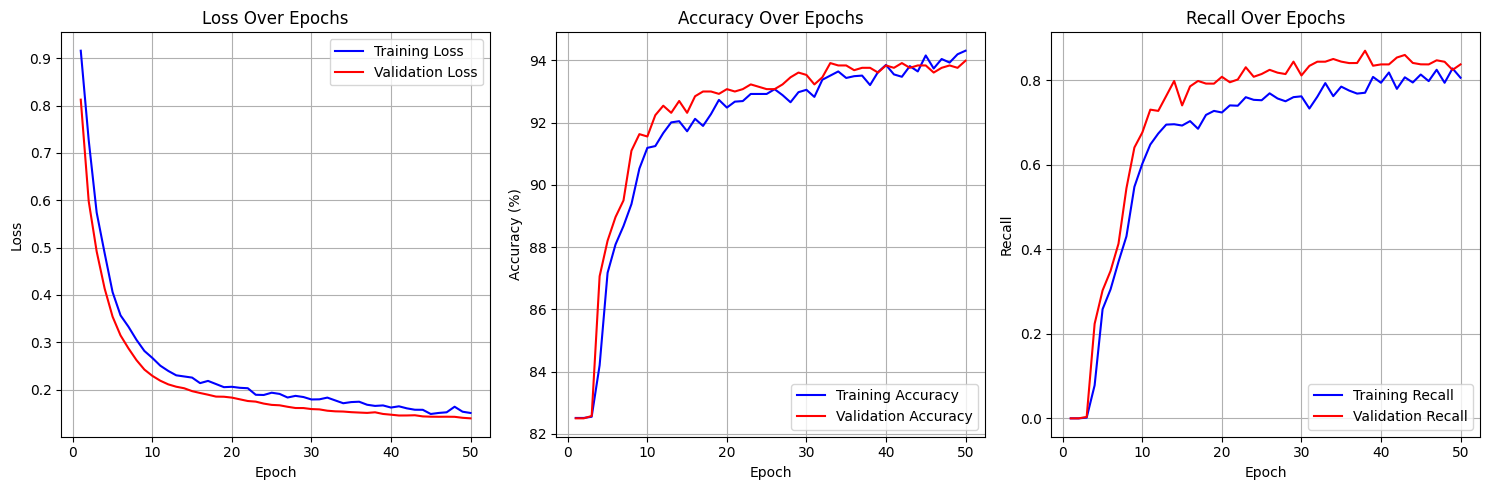

In [9]:
from utils.plot_functions import plot_metrics
plot_metrics(metrics)

Observamos que el modelo Random Forest sigue siendo mejor que la red neuronal que hemos probado.

## Limitaciones

Hay que tener en cuenta que este ejemplo se centra en el procedimiento de comparación entre modelos. Sería razonable para ambos modelos realizar un ajuste de hiperparámetros para obtener el mejor resultado posible. Además, el uso de *cross-validation* para evaluar el modelo de red neuronal es una aproximación más correcta.